# Using convolutions to generalize
- Understanding convolution
- Creating custom `nn.Module` subclasses
- difference between the `nn.module` and `nn.functional` APIs

In [1]:
import torch 
import torchvision
import os
from matplotlib import pyplot as plt
from torchinfo import summary

In [2]:
DATAPATH = r'C:\Users\muthu\GitHub\DATA 📁'

In [3]:
CIFAR10:torchvision.datasets.CIFAR10  = torchvision.datasets.CIFAR10(
                                                    root=DATAPATH,
                                                    download=False,
                                                    transform=torchvision.transforms.Compose([
                                                            torchvision.transforms.ToTensor(),
                                                            torchvision.transforms.Normalize(
                                                                mean=(0.49139968, 0.48215827 ,0.44653124),
                                                                std=(0.24703233 ,0.24348505, 0.26158768))
                                                    ])    
)

print(CIFAR10)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: C:\Users\muthu\GitHub\DATA 📁
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.49139968, 0.48215827, 0.44653124), std=(0.24703233, 0.24348505, 0.26158768))
           )


## What convolutions do
- Convolution, or more precisely, discrete convolution localized patterns to have an effect on the output regardless of their location in the image: that is, to be *translation invariant*
- typically we use small kernels ( optimized for GPU and stacking kernels will result Respective Field Steadly! )
- since it's small parameter model with lot fewer parameters
- `nn.Conv2d` expects a *( Batch x Channel x Height x Width )* shape as tensor

<div align='center'> <img src="../assets/locality%20and%20translation%20invariance.png" alt="convolution" height=500 width=1000></img> </div>


## Padding, and Maxpooling
##### padding 
- helps in size of an image adjustments (U-Net / Residual Connection) 
- separate the matter of convolution (changing image sizes) by creating *ghost* pixels around the border

<div align='center'> <img src="../assets/padding.png" alt="convolution" height=500 width=1000 />  </div>

##### MaxPooling
combining convolutions and downsampling for great good and increase in RF
<div align='center'>  <img src="../assets/maxpool.png" alt="maxpool" height=500 width=1000 /> </div>




## Detecting features with convoltuions

<div align='center'> <img src="../assets/learning%20with%20conv.png" height=500 width=1000></img> </div>

In fact, the job of a computer vision expert has historically been to come up with the most effective combination of filters so that certain features are highlighted in images and objects can be recognized.

Here we let model to figure it out.

torch.Size([1, 3, 32, 32]) torch.Size([1, 16, 30, 30])


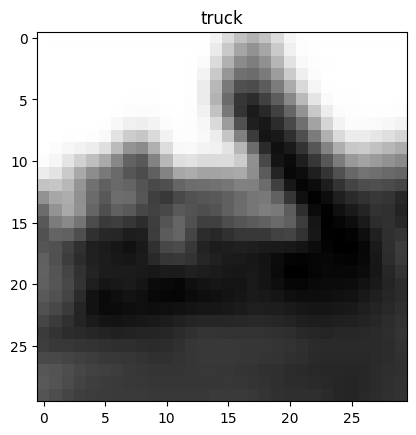

In [4]:
conv = torch.nn.Conv2d(3,16,kernel_size=3,padding=0,stride=1,bias=True)

## Average Kernel (Blurr)
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1./4.0)

##  Edge-Detection Kernel 
# with torch.no_grad():
#     conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0],[-1.0, 0.0, 1.0]])


img, label = CIFAR10[2]
output     = conv(img.unsqueeze(0))
print(img.unsqueeze(0).shape, output.shape)

plt.imshow(output[0,0].detach().cpu().numpy(),cmap='gray')
plt.title(CIFAR10.classes[label])
plt.show()

## Putting it all together
```python
 model = nn.Sequential(
                torch.torch.torch.torch.nn.Conv2d(3, 16, kernel_size=3, padding=1),
                torch.torch.nn.Tanh(),
                nn.MaxPool2d(2),
                nn.Conv2d(16, 8, kernel_size=3, padding=1),
                nn.Tanh(),
                nn.MaxPool2d(2),
                # ...
                nn.Linear(8 * 8 * 8, 32),
                nn.Tanh(),
                nn.Linear(32, 2))
```
<div align='center'> 
    <img src="../assets/typical%20cnn%20architecture.png" alt="typical cnn architecture" height=500 width=1000>
</div>

## Subclassing `nn.Module`
-  How PyTorch keeps track of parameters and submodules

In order to subclass `nn.Module` at minimum we need to define `forward` function that takes the inputs to the module and returns the output. backward propagation will take care by autograd automatically.
 
`Note`
you need to call `super().__init__()` before you can do that (or PyTorch will remind you)

The submodules must be top-level attributes, not buried inside list or dict instance. Otherwise optimizer will not able to locate the submodules use `nn.ModuleList` and `nn.ModuleDict`



In [5]:
class Net(torch.nn.Module):
    def __init__(self, in_channels=3,out_channels=2):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels,16,kernel_size=3,padding=1)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(16,8,kernel_size=3,padding=1)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.MaxPool2d(2)
        self.fc1   = torch.nn.Linear(8*8*8,32)
        self.act3  = torch.nn.Tanh()
        self.fc2   = torch.nn.Linear(32,out_channels) 

    def forward(self,x, *args, **kwargs):
        out = self.pool1( self.act1( self.conv1(x) ) )
        out = self.pool2( self.act2( self.conv2(out) ) )
        out = out.view(-1,8*8*8)
        out = self.fc2( self.act3(self.fc1(out)) )
        return out

In [6]:
model = Net(in_channels=3,out_channels=2)
print(f"number of parameters:: {sum(p.numel() for p in model.parameters() )}")

summary(
        model=model, 
        input_size=(1,3,32,32),
        col_width=20,
        row_settings=["depth","var_names"],
        col_names=["input_size","output_size","num_params","params_percent", "kernel_size","mult_adds","trainable"]
)

number of parameters:: 18090


Layer (type (var_name):depth-idx)        Input Shape          Output Shape         Param #              Param %              Kernel Shape         Mult-Adds            Trainable
Net (Net)                                [1, 3, 32, 32]       [1, 2]               --                        --              --                   --                   True
├─Conv2d (conv1): 1-1                    [1, 3, 32, 32]       [1, 16, 32, 32]      448                    2.48%              [3, 3]               458,752              True
├─Tanh (act1): 1-2                       [1, 16, 32, 32]      [1, 16, 32, 32]      --                        --              --                   --                   --
├─MaxPool2d (pool1): 1-3                 [1, 16, 32, 32]      [1, 16, 16, 16]      --                        --              2                    --                   --
├─Conv2d (conv2): 1-4                    [1, 16, 16, 16]      [1, 8, 16, 16]       1,160                  6.41%              [3, 3]        

## The functional API `nn.functional`

By "functional" here we mean "having no internal state"

In [7]:
from torch.nn import functional as F

class NetF(torch.nn.Module):
    def __init__(self,in_channels=3,out_channels=2):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(8 * 8 * 8, 32)
        self.fc2 = torch.nn.Linear(32, out_channels)
    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    

model = NetF(in_channels=3,out_channels=2)
print(f"number of parameters:: {sum(p.numel() for p in model.parameters() )}")

summary(
        model=model, 
        input_size=(1,3,32,32),
        col_width=20,
        row_settings=["depth","var_names"],
        col_names=["input_size","output_size","num_params","params_percent", "kernel_size","mult_adds","trainable"]
)

number of parameters:: 18090


Layer (type (var_name):depth-idx)        Input Shape          Output Shape         Param #              Param %              Kernel Shape         Mult-Adds            Trainable
NetF (NetF)                              [1, 3, 32, 32]       [1, 2]               --                        --              --                   --                   True
├─Conv2d (conv1): 1-1                    [1, 3, 32, 32]       [1, 16, 32, 32]      448                    2.48%              [3, 3]               458,752              True
├─Conv2d (conv2): 1-2                    [1, 16, 16, 16]      [1, 8, 16, 16]       1,160                  6.41%              [3, 3]               296,960              True
├─Linear (fc1): 1-3                      [1, 512]             [1, 32]              16,416                90.75%              --                   16,416               True
├─Linear (fc2): 1-4                      [1, 32]              [1, 2]               66                     0.36%              --        

Later,  we will briefly touch on quantization. Then stateless bits like activations suddenly become stateful because information about the quantization needs to be captured. This means if we aim to quantize our model, it might be worthwhile to stick with the modular API if we go for non-JITed quantization


Recall that the core of our convnet is two nested loops: an outer one over the `epochs` and an inner one of the DataLoader that produces `batches` from our Dataset.

In each loop, we then have to
 - Feed the inputs through the model (the forward pass).
 - Compute the loss (also part of the forward pass).
 - Zero any old gradients.
 - Call loss.backward() to compute the gradients of the loss with respect to all parameters (the backward pass).
 - Have the optimizer take a step in toward lower loss.

## Model design

### Adding memory capacity: Width
- First dimension is **Width** of the network: number of channels per convolution

### Helping our model to converge and generalize: Regualarization and Dropout
- **L1** and **L2** norm
- dropout should normally active when model training.


### KEEPING ACTIVATIONS IN CHECK: BATCH NORMALIZATION
- Reducing the internal convariate sift (address different features present in different channels)

### Going deeper to learn more complex structures: Depth (Residual Connection)
- Since this is a deep learning, depth is something we’re supposedly into.
-  Depth allows a model to deal with hierarchical information when we need to understand the context in order to say something about some input.
- A skip connection is nothing but the addition of the input to the output of a block of layers.
<div align='center'>
    <img src="../assets/residual connection.png" height=600 width=300  alt='residual'/>
</div>

we're using the output of the first activations as inputs to the last, in addition to standard feed-forward path. This is referred as `identity mapping`. It's not new Highway networks and U-Net made use of skip connections of one-form or another.

In [8]:
class NetRes(torch.nn.Module):
  def __init__(self, n_chans1:int=32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = torch.nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv2 = torch.nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
    self.conv3 = torch.nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
    self.fc1 = torch.nn.Linear(4 * 4 * n_chans1 // 2, 32)
    self.fc2 = torch.nn.Linear(32, 2)
  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
    out1 = out
    out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
    out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out

In [9]:
modelF = NetRes(n_chans1=32)
summary(model=modelF,input_size=(3,32,32),col_width=20,
        row_settings=["depth","var_names"],
        col_names=["input_size","output_size","num_params","params_percent", "kernel_size","mult_adds","trainable"])

Layer (type (var_name):depth-idx)        Input Shape          Output Shape         Param #              Param %              Kernel Shape         Mult-Adds            Trainable
NetRes (NetRes)                          [3, 32, 32]          [1, 2]               --                        --              --                   --                   True
├─Conv2d (conv1): 1-1                    [3, 32, 32]          [32, 32, 32]         896                    5.55%              [3, 3]               917,504              True
├─Conv2d (conv2): 1-2                    [32, 16, 16]         [16, 16, 16]         4,624                 28.67%              [3, 3]               1,183,744            True
├─Conv2d (conv3): 1-3                    [16, 8, 8]           [16, 8, 8]           2,320                 14.38%              [3, 3]               296,960              True
├─Linear (fc1): 1-4                      [1, 256]             [1, 32]              8,224                 50.99%              --        

<h1 align='center'>Deep Network</h1>
<div align='center'>
    <img src="../assets/deep nn.png" alt='deep nn' height=700 width=500></img>
</div>

In [10]:
class ResBlock(torch.nn.Module):
  def __init__(self, n_chans:int):
    super(ResBlock, self).__init__()
    self.conv = torch.nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
    self.batch_norm = torch.nn.BatchNorm2d(num_features=n_chans)
    torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
    torch.nn.init.constant_(self.batch_norm.weight, 0.5)
    torch.nn.init.zeros_(self.batch_norm.bias)
    
  def forward(self, x):
    out = self.conv(x)
    out = self.batch_norm(out)
    out = torch.relu(out)
    return out + x

class NetResDeep(torch.nn.Module):
  def __init__(self, n_chans1=32, n_blocks=1):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = torch.nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.resblocks = torch.nn.Sequential(
                *( n_blocks* [ResBlock(n_chans=n_chans1)] )
    )
    self.fc1 = torch.nn.Linear(8 * 8 * n_chans1, 32)
    self.fc2 = torch.nn.Linear(32, 2)
  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = self.resblocks(out)
    out = F.max_pool2d(out, 2)
    out = out.view(-1, 8 * 8 * self.n_chans1)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out

In [11]:
modelDeep = NetResDeep(n_chans1=32,n_blocks=5)
summary(
    model=modelDeep,
    input_size=(1,3,32,32),
    col_width=20,
    row_settings=["depth","var_names"],
    col_names=["input_size","output_size","num_params","params_percent", "kernel_size","mult_adds","trainable"]
)

Layer (type (var_name):depth-idx)                  Input Shape          Output Shape         Param #              Param %              Kernel Shape         Mult-Adds            Trainable
NetResDeep (NetResDeep)                            [1, 3, 32, 32]       [1, 2]               --                        --              --                   --                   True
├─Conv2d (conv1): 1-1                              [1, 3, 32, 32]       [1, 32, 32, 32]      896                    1.18%              [3, 3]               917,504              True
├─Sequential (resblocks): 1-2                      [1, 32, 16, 16]      [1, 32, 16, 16]      --                        --              --                   --                   True
│    └─ResBlock (4): 2-1                           [1, 32, 16, 16]      [1, 32, 16, 16]      --                        --              --                   --                   True
│    │    └─Conv2d (conv): 3-1                     [1, 32, 16, 16]      [1, 32, 16, 1

### Exercise

In [12]:
class ResBlock(torch.nn.Module):
  def __init__(self, n_chans:int):
    super(ResBlock, self).__init__()
    self.conv = torch.nn.Conv2d(n_chans, n_chans, kernel_size=5, padding=2, bias=False)
    self.batch_norm = torch.nn.BatchNorm2d(num_features=n_chans)
    torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
    torch.nn.init.constant_(self.batch_norm.weight, 0.5)
    torch.nn.init.zeros_(self.batch_norm.bias)
    
  def forward(self, x):
    out = self.conv(x)
    out = self.batch_norm(out)
    out = torch.relu(out)
    return out + x

class NetResDeep(torch.nn.Module):
  def __init__(self, n_chans1=32, n_blocks=1):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = torch.nn.Conv2d(3, n_chans1, kernel_size=5, padding=2)
    self.resblocks = torch.nn.Sequential(
                *( n_blocks* [ResBlock(n_chans=n_chans1)] )
    )
    self.fc1 = torch.nn.Linear(8 * 8 * n_chans1, 32)
    self.fc2 = torch.nn.Linear(32, 2)
  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = self.resblocks(out)
    out = F.max_pool2d(out, 2)
    out = out.view(-1, 8 * 8 * self.n_chans1)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out

In [13]:
modelDeep = NetResDeep(n_chans1=32,n_blocks=5)
summary(
    model=modelDeep,
    input_size=(1,3,32,32),
    col_width=20,
    row_settings=["depth","var_names"],
    col_names=["input_size","output_size","num_params","params_percent", "kernel_size","mult_adds","trainable"]
)

Layer (type (var_name):depth-idx)                  Input Shape          Output Shape         Param #              Param %              Kernel Shape         Mult-Adds            Trainable
NetResDeep (NetResDeep)                            [1, 3, 32, 32]       [1, 2]               --                        --              --                   --                   True
├─Conv2d (conv1): 1-1                              [1, 3, 32, 32]       [1, 32, 32, 32]      2,432                  2.59%              [5, 5]               2,490,368            True
├─Sequential (resblocks): 1-2                      [1, 32, 16, 16]      [1, 32, 16, 16]      --                        --              --                   --                   True
│    └─ResBlock (4): 2-1                           [1, 32, 16, 16]      [1, 32, 16, 16]      --                        --              --                   --                   True
│    │    └─Conv2d (conv): 3-1                     [1, 32, 16, 16]      [1, 32, 16, 1